# gRPC Remote Inference

Now that we've served the model using RHODS Model Serving, we can explore how to use those APIs as an exercise.  First, to use each model, we'll [deconstruct the stable diffusion pipeline](https://huggingface.co/docs/diffusers/using-diffusers/write_own_pipeline#deconstruct-the-stable-diffusion-pipeline).  As shown in these examples of using [Huggingface pretrained weights](misc-notebooks/stable_diffusion_huggingface.ipynb), [custom pretrained weights](misc-notebooks/stable_diffusion_huggingface_finetuned.ipynb), [local weights](text-to-image-demo/misc-notebooks/stable_diffusion_local.ipynb), we're going to replace our inference with calls to gRPC and use the models in a very similar fashion.

This notebook assumes you've deployed the 4 onnx models created in Notebook 2, either manually or by importing [serving/models.yaml](serving/models.yaml)

### Install Dependencies

As we're going to be making gRPC requests, we'll need to use grpc libraries.

In [1]:
!pip install -q --upgrade accelerate transformers ftfy
!pip install -q git+https://github.com/huggingface/diffusers


[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: pip install --upgrade pip


In [2]:
!pip install grpcio==1.56.0 grpcio-tools==1.33.2


[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: pip install --upgrade pip


In [3]:
!pip list | grep -e grpcio -e protobuf

grpcio                          1.56.0
grpcio-tools                    1.33.2
protobuf                        3.20.3

[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: pip install --upgrade pip


### The gRPC Connection

The models are deployed in the same namespace as part of ModelMesh.  We can find these settings in the RHODS UI.

After specifying the locations, we load python libraries generated from the [Kserve proto](https://github.com/kserve/kserve/blob/master/docs/predict-api/v2/grpc_predict_v2.proto).

In [4]:
grpc_host = 'modelmesh-serving'
grpc_port = 8033

textencoder_model_name = 'textencoder'
unet_model_name = 'unet'
vaeencoder_model_name = 'vaeencoder'
vaedecoder_model_name = 'vaedecoder'

In [5]:
import sys
sys.path.append('./serving')

import grpc
import serving.grpc_predict_v2_pb2 as grpc_predict_v2_pb2
import serving.grpc_predict_v2_pb2_grpc as grpc_predict_v2_pb2_grpc

channel = grpc.insecure_channel(f"{grpc_host}:{grpc_port}")
stub = grpc_predict_v2_pb2_grpc.GRPCInferenceServiceStub(channel)


### Replace models with gRPC calls

Now instead of loading the model in PyTorch, we can create functions to make remote calls with the same argument data.


In [6]:
from PIL import Image
import numpy as np
import torch
from transformers import CLIPTextModel, CLIPTokenizer
from diffusers import AutoencoderKL, UNet2DConditionModel, PNDMScheduler

# replace text decoder with grpc requests
# vae = AutoencoderKL.from_pretrained("runwayml/stable-diffusion-v1-5", subfolder="vae", use_safetensors=True)
def vae_decoder_grpc_request(latent_sample):
    inputs = []
    inputs.append(grpc_predict_v2_pb2.ModelInferRequest().InferInputTensor())
    inputs[0].name = "latent_sample"
    inputs[0].datatype = "FP32"
    inputs[0].shape.extend([1, 4, 64, 64])
    arr = latent_sample.flatten()
    inputs[0].contents.fp32_contents.extend(arr)

    request = grpc_predict_v2_pb2.ModelInferRequest()
    request.model_name = vaedecoder_model_name
    request.inputs.extend(inputs)

    response = stub.ModelInfer(request)
    out_sample = np.frombuffer(response.raw_output_contents[0], dtype=np.float32)

    return torch.tensor(out_sample.reshape([1, 3, 512, 512]))


tokenizer = CLIPTokenizer.from_pretrained("runwayml/stable-diffusion-v1-5", subfolder="tokenizer")


# replace text encoder with grpc requests
# text_encoder = CLIPTextModel.from_pretrained(
#     "runwayml/stable-diffusion-v1-5", subfolder="text_encoder", use_safetensors=False
# )

def textencoder_grpc_request(input_arr):
    inputs = []
    inputs.append(grpc_predict_v2_pb2.ModelInferRequest().InferInputTensor())
    inputs[0].name = "input_ids"
    inputs[0].datatype = "INT32"
    inputs[0].shape.extend([1, 77])
    arr = input_arr.flatten()
    inputs[0].contents.int_contents.extend(arr)

    request = grpc_predict_v2_pb2.ModelInferRequest()
    request.model_name = textencoder_model_name
    request.inputs.extend(inputs)

    response = stub.ModelInfer(request)
    text_embeddings = np.frombuffer(response.raw_output_contents[0], dtype=np.float32)

    return torch.tensor(text_embeddings.reshape([-1, 77, 768]), dtype=torch.float32)


# unet = UNet2DConditionModel.from_pretrained(
#     "runwayml/stable-diffusion-v1-5", subfolder="unet", use_safetensors=False
# )

def unet_grpc_request(encoder_hidden_states, timestep, sample):
    inputs = []
    inputs.append(grpc_predict_v2_pb2.ModelInferRequest().InferInputTensor())
    inputs[0].name = "encoder_hidden_states"
    inputs[0].datatype = "FP32"
    inputs[0].shape.extend([2, 77, 768])
    arr = encoder_hidden_states.flatten()
    inputs[0].contents.fp32_contents.extend(arr)

    inputs.append(grpc_predict_v2_pb2.ModelInferRequest().InferInputTensor())
    inputs[1].name = "timestep"
    inputs[1].datatype = "INT64"
    inputs[1].shape.extend([2, 1])
    arr = timestep.flatten()
    inputs[1].contents.int64_contents.extend(arr)

    inputs.append(grpc_predict_v2_pb2.ModelInferRequest().InferInputTensor())
    inputs[2].name = "sample"
    inputs[2].datatype = "FP32"
    inputs[2].shape.extend([2, 4, 64, 64])
    arr = sample.flatten()
    inputs[2].contents.fp32_contents.extend(arr)

    request = grpc_predict_v2_pb2.ModelInferRequest()
    request.model_name = unet_model_name
    request.inputs.extend(inputs)

    response = stub.ModelInfer(request)
    out_sample = np.frombuffer(response.raw_output_contents[0], dtype=np.float32)

    return torch.tensor(out_sample.reshape([-1, 4, 64, 64]), dtype=torch.float32)

A matching Triton is not available, some optimizations will not be enabled.
Error caught was: No module named 'triton'


We can still use the schedule, but now without an gpus which have been offloaded to the model server.

In [7]:
from diffusers import DDIMScheduler

scheduler = DDIMScheduler.from_pretrained("cfchase/stable-diffusion-rhteddy", subfolder="scheduler")

In [8]:
# just use cpu and offload gpu requests to grpc server
torch_device = "cpu"

#replace inference with gRPC
# vae.to(torch_device)
# text_encoder.to(torch_device)
# unet.to(torch_device)

This time, let's put Teddy in a new location... the beach!

In [9]:
prompt = ["a photo of a rhteddy dog on the beach"]
height = 512  # default height of Stable Diffusion
width = 512  # default width of Stable Diffusion
num_inference_steps = 50  # Number of denoising steps
guidance_scale = 7.5  # Scale for classifier-free guidance

# Seed generator to create the inital latent noise
# generator = torch.manual_seed(0)  # manual
generator = torch.Generator()  # random

batch_size = len(prompt)

In [10]:
import numpy as np

text_input = tokenizer(
    prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt"
)
with torch.no_grad():
    text_encoder_args = text_input.input_ids.to(torch_device)
    
    # replace text encoder with grpc requests
    # text_embeddings = text_encoder(text_encoder_args)[0]
    text_embeddings = textencoder_grpc_request(text_input.input_ids.numpy())


In [11]:
max_length = text_input.input_ids.shape[-1]
uncond_input = tokenizer([""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt")

# replace text encoder with grpc requests
# uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0]
uncond_embeddings = textencoder_grpc_request(uncond_input.input_ids.numpy())

In [12]:
text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

In [13]:
latents = torch.randn(
    #(batch_size, unet.in_channels, height // 8, width // 8),
    (batch_size, 4, height // 8, width // 8),
    generator=generator,
)
latents = latents.to(torch_device)

In [14]:
from tqdm.auto import tqdm
import torch

scheduler.set_timesteps(num_inference_steps)

for t in tqdm(scheduler.timesteps):
    # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
    latent_model_input = torch.cat([latents] * 2)

    latent_model_input = scheduler.scale_model_input(latent_model_input, timestep=t)
    
    # replace unet encoder with grpc requests

    # predict the noise residual
    # with torch.no_grad():
        # noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample

    # torch.tensor([t, t]) instead of t to workaround batch error on triton grpc
    noise_pred = unet_grpc_request(text_embeddings, torch.tensor([t, t]), latent_model_input)

    # perform guidance
    noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
    noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

    # compute the previous noisy sample x_t -> x_t-1
    latents = scheduler.step(noise_pred, t, latents).prev_sample

  0%|          | 0/50 [00:00<?, ?it/s]

In [15]:
import numpy as np

# scale and decode the image latents with vae
latents = 1 / 0.18215 * latents

# replace vae decoder with grpc requests
# with torch.no_grad():
    # image = vae.decode(latents).sample   
image = vae_decoder_grpc_request(latents)

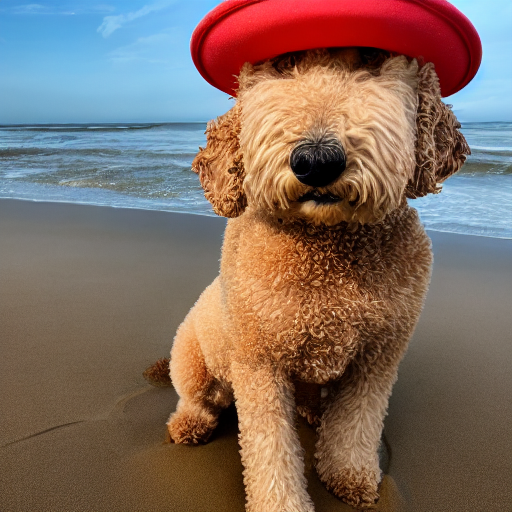

In [16]:
image = (image / 2 + 0.5).clamp(0, 1).squeeze()
image = (image.permute(1, 2, 0) * 255).to(torch.uint8).cpu().numpy()
images = (image * 255).round().astype("uint8")
image = Image.fromarray(image)
image

Did Teddy go to the beach?